In [ ]:
#paths
OUTPUT_FOLDER = "" # output directory
import os
os.makedirs(OUTPUT_FOLDER,exist_ok=True)

CHECKPOINT_PATH= "" # trainingscirp checkpoint path #TODO shouldn't be needed.
IMAGENET_PATH = "" #'folder containing imagenet1k data organized as follows: https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description'

SAE_PATH = ""# path to SAE folder, might look something like "final_sae_group_wkcn_TinyCLIP-ViT-40M-32-Text-19M-LAION400M_blocks.{layer}.mlp.hook_post_16384" 
#(legacy load takes in the pt file)
AUTOENCODER_NAME = "" #name of the particular sae within group (all names will get printed below )
#model specs TODO these should be infered from pretrained model checkpoint (if they aren't already)
LAYERS =  9
EXPANSION_FACTOR = 8
D_IN = 2048
MODEL_NAME = "wkcn/TinyCLIP-ViT-40M-32-Text-19M-LAION400M"
CONTEXT_SIZE = 50 
PATCH_SIZE = 32
HOOKPOINT = "blocks.{layer}.mlp.hook_post"

LEGACY_LOAD= False




In [ ]:
# eval constants

EVAL_MAX = 50_000 
BATCH_SIZE = 32


In [ ]:
from sae.main import setup, ImageNetValidationDataset
import torch
import plotly.express as px
from typing import List

import torch
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torchvision
import einops
from transformers import CLIPProcessor
from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT
from typing import List

device = "cuda"

torch.set_grad_enabled(False)


In [ ]:
# setup eval data 
clip_processor = CLIPProcessor.from_pretrained(MODEL_NAME)

data_transforms_list = [
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=clip_processor.image_processor.image_mean,
                        std=clip_processor.image_processor.image_std)]
data_transforms = torchvision.transforms.Compose(data_transforms_list)



# assuming the same structure as here: https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description
imagenet_val_path  =os.path.join(IMAGENET_PATH, "ILSVRC/Data/CLS-LOC/val")
imagenet_val_labels = os.path.join(IMAGENET_PATH, "LOC_val_solution.csv")
imagenet_label_strings = os.path.join(IMAGENET_PATH, "LOC_synset_mapping.txt" )
imagenet_data = ImageNetValidationDataset(imagenet_val_path,imagenet_label_strings, imagenet_val_labels ,data_transforms, return_index=True)
imagenet_data_visualize = ImageNetValidationDataset(imagenet_val_path,imagenet_label_strings, imagenet_val_labels ,torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

data_loader = DataLoader(imagenet_data, batch_size=BATCH_SIZE, shuffle=False)


ind_to_name = {}

with open( os.path.join(IMAGENET_PATH, "LOC_synset_mapping.txt" ), 'r') as file:
    # Iterate over each line in the file
    for line_num, line in enumerate(file):
        line = line.strip()
        if not line:
            continue
        parts = line.split(' ')
        label = " ".join(parts[1:])
        ind_to_name[line_num] = label


# setup model
cfg ,model, activations_loader, sae_group = setup(checkpoint_path=CHECKPOINT_PATH, 
                                                  imagenet_path=IMAGENET_PATH ,
                                                    pretrained_path=SAE_PATH, layers= LAYERS, expansion_factor=EXPANSION_FACTOR,
                                                    model_name=MODEL_NAME, context_size=CONTEXT_SIZE, d_in=D_IN, hook_point=HOOKPOINT, legacy_load=LEGACY_LOAD)
model = model.to(device)
for i, (name, sae) in enumerate(sae_group):
    hyp = sae.cfg
    print(
        f"{i}: Name: {name} Layer {hyp.hook_point_layer}, p_norm {hyp.lp_norm}, alpha {hyp.l1_coefficient}"
    )

sparse_autoencoder = sae_group.autoencoders[AUTOENCODER_NAME]
sparse_autoencoder = sparse_autoencoder.to(device)
layer_num = sparse_autoencoder.cfg.hook_point_layer
print(f"Chosen layer {layer_num} hook point {sparse_autoencoder.cfg.hook_point}")

In [ ]:
sparse_autoencoder.eval() 

In [ ]:
FEATURE = 2381

In [ ]:

from transformers import CLIPModel


# clip imagenet projections

full_clip_model = CLIPModel.from_pretrained(MODEL_NAME)
full_clip_model.to(device)
text_model = full_clip_model.text_model
text_projection = full_clip_model.text_projection
# classes = list(IMAGENET_DICT.values())
# imagenet1k_class_labels_input = clip_processor(text=classes, return_tensors='pt',  padding=True).input_ids
# imagenet1k_class_labels_input = imagenet1k_class_labels_input.to(device)

# imagenet1k_class_labels_projections = text_projection(text_model(imagenet1k_class_labels_input)[1])
# imagenet1k_class_labels_projections_normalized = torch.nn.functional.normalize(imagenet1k_class_labels_projections, p=2, dim=-1)

torch.Size([3, 224, 224])


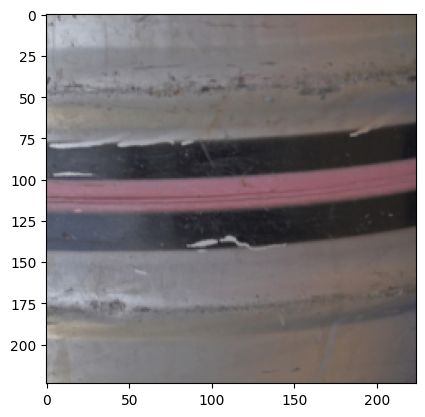

427
['barrel, cask', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label        Original   Steered    Diff      
---------------------
barrel, cask 0.229      0.224      -0.005    
mustache     0.193      0.200      0.006     
whiskers     0.192      0.194      0.001     
facial hair  0.143      0.146      0.003     
snake        0.216      0.215      -0.001    
slug         0.226      0.224      -0.002    
dog          0.217      0.214      -0.003    
door         0.214      0.210      -0.003    
cat          0.214      0.213      -0.002    
car          0.230      0.230      0.000     
torch.Size([3, 224, 224])


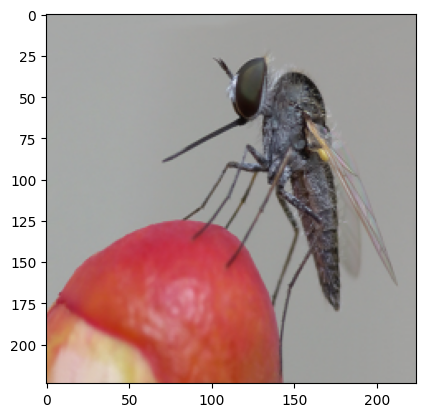

308
['fly', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label       Original   Steered    Diff      
---------------------
fly         0.269      0.266      -0.002    
mustache    0.135      0.148      0.013     
whiskers    0.153      0.162      0.009     
facial hair 0.104      0.111      0.007     
snake       0.182      0.182      0.000     
slug        0.226      0.226      -0.000    
dog         0.187      0.186      -0.002    
door        0.161      0.158      -0.003    
cat         0.178      0.177      -0.001    
car         0.206      0.204      -0.003    
torch.Size([3, 224, 224])


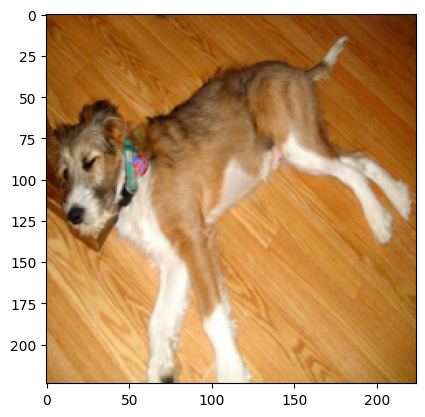

175
['otterhound, otter hound', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label                   Original   Steered    Diff      
---------------------
otterhound, otter hound 0.261      0.267      0.006     
mustache                0.218      0.229      0.011     
whiskers                0.221      0.227      0.006     
facial hair             0.174      0.183      0.008     
snake                   0.188      0.189      0.001     
slug                    0.204      0.208      0.004     
dog                     0.276      0.274      -0.001    
door                    0.159      0.155      -0.004    
cat                     0.223      0.223      0.000     
car                     0.215      0.215      -0.000    
torch.Size([3, 224, 224])


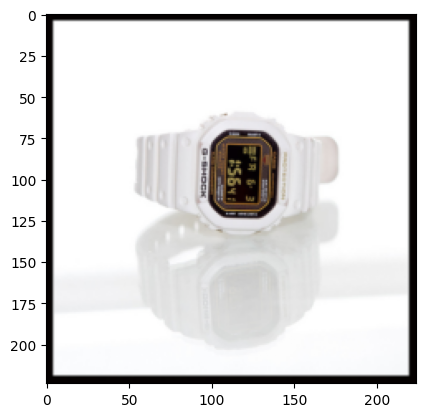

530
['digital clock', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label         Original   Steered    Diff      
---------------------
digital clock 0.240      0.234      -0.006    
mustache      0.150      0.163      0.013     
whiskers      0.112      0.116      0.004     
facial hair   0.117      0.125      0.008     
snake         0.213      0.213      0.000     
slug          0.219      0.222      0.003     
dog           0.208      0.209      0.001     
door          0.131      0.128      -0.003    
cat           0.207      0.208      0.001     
car           0.211      0.213      0.002     
torch.Size([3, 224, 224])


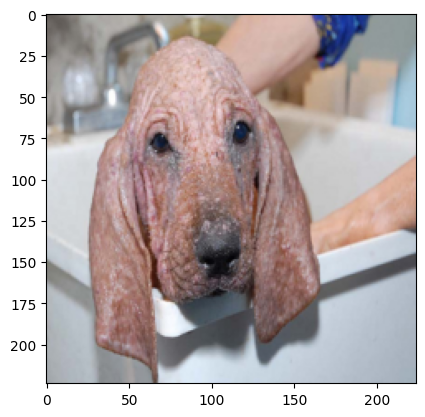

168
['redbone', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label       Original   Steered    Diff      
---------------------
redbone     0.158      0.158      0.000     
mustache    0.180      0.191      0.010     
whiskers    0.171      0.176      0.004     
facial hair 0.180      0.188      0.008     
snake       0.177      0.179      0.002     
slug        0.223      0.227      0.004     
dog         0.249      0.248      -0.002    
door        0.117      0.117      -0.000    
cat         0.191      0.191      -0.000    
car         0.179      0.181      0.001     
torch.Size([3, 224, 224])


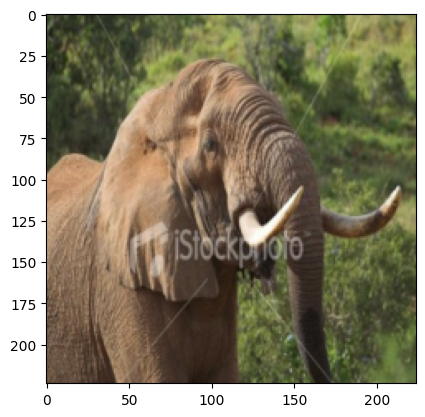

386
['African elephant, Loxodonta africana', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label                                Original   Steered    Diff      
---------------------
African elephant, Loxodonta africana 0.330      0.326      -0.004    
mustache                             0.176      0.182      0.006     
whiskers                             0.146      0.149      0.004     
facial hair                          0.135      0.141      0.006     
snake                                0.190      0.188      -0.002    
slug                                 0.206      0.204      -0.002    
dog                                  0.199      0.195      -0.004    
door                                 0.156      0.151      -0.005    
cat                                  0.176      0.172      -0.005    
car                                  0.206      0.201      -0.005    
torch.Size([3, 224, 224])


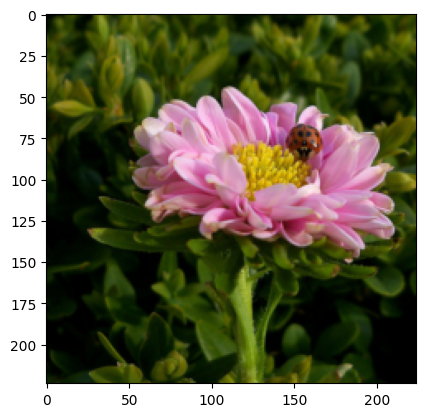

301
['ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label                                                       Original   Steered    Diff      
---------------------
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle 0.254      0.246      -0.008    
mustache                                                    0.126      0.135      0.009     
whiskers                                                    0.120      0.126      0.006     
facial hair                                                 0.077      0.084      0.007     
snake                                                       0.181      0.180      -0.001    
slug                                                        0.220      0.220      0.000     
dog                                                         0.202      0.201      -0.001    
door                                                        0.147      0.144     

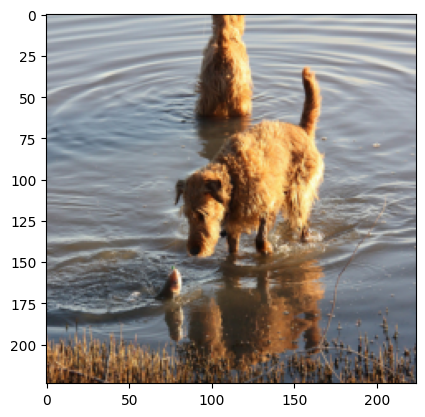

184
['Irish terrier', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label         Original   Steered    Diff      
---------------------
Irish terrier 0.316      0.314      -0.003    
mustache      0.171      0.178      0.006     
whiskers      0.210      0.211      0.001     
facial hair   0.108      0.115      0.007     
snake         0.170      0.169      -0.001    
slug          0.188      0.189      0.001     
dog           0.266      0.263      -0.003    
door          0.140      0.136      -0.004    
cat           0.215      0.213      -0.003    
car           0.192      0.190      -0.002    
torch.Size([3, 224, 224])


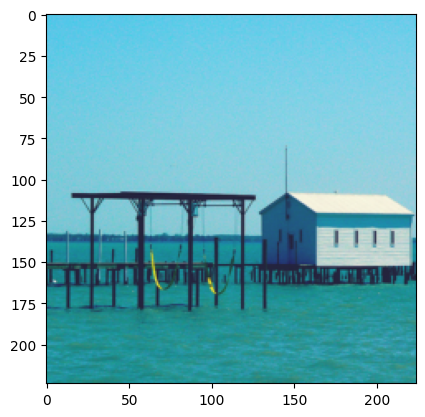

449
['boathouse', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label       Original   Steered    Diff      
---------------------
boathouse   0.289      0.291      0.003     
mustache    0.136      0.146      0.010     
whiskers    0.106      0.112      0.006     
facial hair 0.092      0.100      0.007     
snake       0.138      0.136      -0.003    
slug        0.185      0.186      0.001     
dog         0.174      0.170      -0.004    
door        0.155      0.149      -0.006    
cat         0.172      0.168      -0.003    
car         0.190      0.187      -0.003    
torch.Size([3, 224, 224])


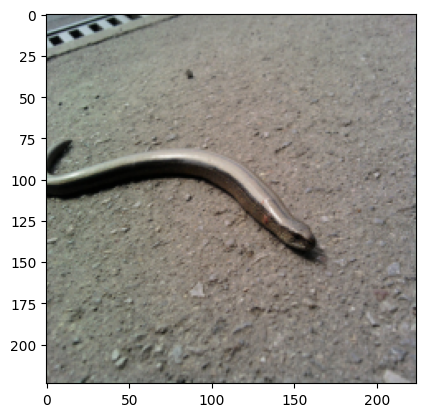

52
['thunder snake, worm snake, Carphophis amoenus', 'mustache', 'whiskers', 'facial hair', 'snake', 'slug', 'dog', 'door', 'cat', 'car']
Label                                         Original   Steered    Diff      
---------------------
thunder snake, worm snake, Carphophis amoenus 0.317      0.312      -0.006    
mustache                                      0.247      0.252      0.005     
whiskers                                      0.218      0.219      0.001     
facial hair                                   0.177      0.182      0.004     
snake                                         0.307      0.303      -0.004    
slug                                          0.279      0.276      -0.003    
dog                                           0.238      0.236      -0.003    
door                                          0.214      0.212      -0.002    
cat                                           0.243      0.240      -0.003    
car                                           0.25

In [121]:

from fancy_einsum import einsum


max_activation =0.050 # TODO  should compute this val. This is correct for mustache
multipler = 10 # TODO try within -10 to 10 accoding to anthropic, might not apply to this model/layer though Seems to need stronger. Kinda makes sense since it's mlp_ot
hookpoint_name = HOOKPOINT.format(layer=LAYERS)

for _ in range(10):
    ### get image 

    sample_image_id = np.random.randint(0,len(imagenet_data_visualize))
    sample_image_display, gt_cls_id, _ = imagenet_data_visualize[sample_image_id]
    sample_image, _ , _ = imagenet_data[sample_image_id]
    sample_image = sample_image.to(device)
    print(sample_image_display.shape)
    sample_image_display = np.transpose(sample_image_display, (1, 2, 0))
    plt.imshow(sample_image_display)
    plt.show()
    print(gt_cls_id)

    #### get labels you want to check against 
    texts = [ind_to_name[gt_cls_id], "mustache", "whiskers", "facial hair", "snake", "slug", "dog", "door", "cat", "car"]
    print(texts)
    text_projections = clip_processor(text=texts, return_tensors='pt',  padding=True).input_ids
    text_projections = text_projections.to(device)
    text_projections = text_projection(text_model(text_projections)[1])
    text_projections = torch.nn.functional.normalize(text_projections, p=2, dim=-1)
    # 

    #TODO legacy load needs to hack this stuff... (should be in the legacy load function)
    if sparse_autoencoder.cfg.scale_sparsity_penalty_by_decoder_norm:
        sparse_autoencoder.get_sparsity_loss_term = sparse_autoencoder.get_sparsity_loss_term_decoder_norm
    else:
        sparse_autoencoder.get_sparsity_loss_term = sparse_autoencoder.get_sparsity_loss_term_standard

    sparse_autoencoder.eval()


    #############
    ################## RUN MODEL WITH STEERING

    def boosting_sae_hook(x, hook):
        #TODO should it only apply to certain patches? unclear.)
        x[:,:,FEATURE] = torch.clamp(x[:,:,FEATURE], min=multipler*max_activation)
        return x 

    def steering_hook(x, hook):
        recon = sparse_autoencoder(x).sae_out
        error = x - recon
        boosted_recon  = sparse_autoencoder.run_with_hooks( ####
            x,
            fwd_hooks=[
            ("hook_hidden_post", boosting_sae_hook)
                ]
        ).sae_out


        return boosted_recon + error  

    embedding = model.run_with_hooks( ####
            sample_image.unsqueeze(0),
            fwd_hooks=[
            (hookpoint_name, steering_hook)
                ]
        )[0]

    ##########
    ######################## One shot classification 
    embedding = embedding/embedding.norm()
    steered_sim = einsum("proj, classes proj -> classes" , embedding, text_projections)






    ### run model normally to compare

    embedding = model(sample_image.unsqueeze(0))[0]

    ##########
    ######################## One shot classification 
    embedding = embedding/embedding.norm()
    original_sim = einsum("proj, classes proj -> classes" , embedding, text_projections)


    max_length_text = max([len(t) for t in texts])
    print(f"{'Label':{max_length_text}} {'Original':10} {'Steered':10} {'Diff':10}")
    print("---------------------")

    # Print the table rows
    for t, s1, s2 in zip(texts, original_sim, steered_sim):
        print(f"{t:{max_length_text}} {s1.item():<10.3f} {s2.item():<10.3f} {s2.item()-s1.item():<10.3f}")
